In [11]:
from glob import glob

import cv2
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import tqdm

import mbb

In [4]:
subset_ffn_list = sorted(glob('/home/meso/data/melb_hailpixel_subset_3_clean/*.png'))

pixel_gsd = 1.4 #pixel ground sample distance in mm

inital_threshold = 0.7 #lightness threshold to use for masking
localmax_mindist = 2 #minimum distance in pixel units between hail centroids
min_area_mm = 3.14*(5**2) #minimum area of hailstone in pixels
min_area = int(min_area_mm/pixel_gsd**2) #minimum area in mm

In [5]:
#core function

def process_subset_image(image_ffn):
    #transform into hsv colorspace
    img_data = cv2.imread(image_ffn)
    img_data_hls = cv2.cvtColor(img_data, cv2.COLOR_BGR2HLS)

    l_data = img_data_hls[:,:,1]/255
    #apply inital threshold
    l_mask = l_data > inital_threshold
    #compute distance transform to find centroids
    l_mask_dist = ndimage.distance_transform_edt(l_mask)
    localMax = peak_local_max(l_mask_dist, indices=False, min_distance=localmax_mindist,
        labels=l_mask)

    #run watershed
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-l_mask_dist, markers, mask=l_mask,watershed_line=True)

    #remove small regions
    region_prop_list = regionprops(labels)
    #build centroid list
    hail_centroid_x = []
    hail_centroid_y = []
    hail_major = []
    hail_minor = []

    for region_prop in region_prop_list:
        if region_prop.area > min_area:
            label_centroid = region_prop.centroid
            hail_centroid_x.append(label_centroid[1])
            hail_centroid_y.append(label_centroid[0])

            hail_pts_i, hail_pts_j = np.where(labels == region_prop.label)
            bounding_box = mbb.MinimumBoundingBox(list(zip(hail_pts_i,hail_pts_j)))

            len_parallel = bounding_box.length_parallel
            len_orthogonal = bounding_box.length_orthogonal

            #work out maj/min axis length
            if len_parallel>len_orthogonal:
                maj_axis_len, min_axis_len = len_parallel, len_orthogonal
            else:
                maj_axis_len, min_axis_len = len_orthogonal, len_parallel

            hail_major.append(maj_axis_len)
            hail_minor.append(min_axis_len)

    hail_centroid_idx = list(range(len(hail_centroid_x)))

    return hail_centroid_x, hail_centroid_y, hail_major, hail_minor, hail_centroid_idx


In [6]:

hail_centroid_x = []
hail_centroid_y = []
hail_major = []
hail_minor = []

for image_ffn in tqdm.tqdm(subset_ffn_list, total=len(subset_ffn_list)):
    
    ss_cx, ss_cy, ss_major, ss_minor, ss_idx = process_subset_image(image_ffn)
    
    hail_centroid_x.extend(ss_cx)
    hail_centroid_y.extend(ss_cy)
    hail_major.extend(ss_major)
    hail_minor.extend(ss_minor)
    
np.savez('test-batch-detection.npz',hail_cx=hail_centroid_x,hail_cy=hail_centroid_y)

  0%|          | 0/128 [00:00<?, ?it/s]/home/meso/miniconda3/envs/hailpixel/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
  1%|          | 1/128 [00:00<02:02,  1.04it/s]/home/meso/miniconda3/envs/hailpixel/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
  2%|▏         | 2/128 [00:01<01:48,  1.16it/s]/home/meso/miniconda3/envs/hailpixel/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation

number of hailstones sampled: 32632


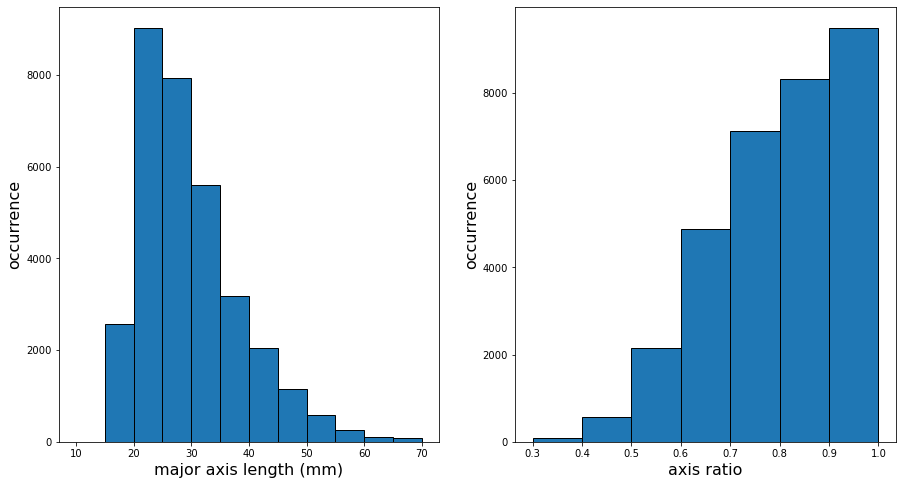

In [16]:
#plot distributions
def plot_stats(hail_maj, hail_min):
    pixel_scaling = 2.6 #mm/pixel
    
    #apply scaling
    hail_maj = hail_maj*pixel_scaling
    hail_min = hail_min*pixel_scaling
    
    # matplotlib histogram
    fig = plt.figure(facecolor='white',figsize=[15, 8])

    plt.subplot(1, 2, 1)
    plt.hist(hail_maj, edgecolor = 'black', bins=np.arange(10,75,5))
    plt.xlabel('major axis length (mm)', fontsize=16)
    plt.ylabel('occurrence', fontsize=16)

    plt.subplot(1, 2, 2)
    plt.hist(hail_min/hail_maj, edgecolor = 'black', bins=np.arange(0.3,1.05,0.1))
    plt.xlabel('axis ratio', fontsize=16)
    plt.ylabel('occurrence', fontsize=16)


hail_major_array = np.array(hail_major)
hail_minor_array = np.array(hail_minor)

print('number of hailstones sampled:', len(hail_major))

plot_stats(hail_major_array, hail_minor_array)

In [27]:
fig = plt.figure(facecolor='white',figsize=[11,10])
ax = plt.subplot()

#apply scaling
pixel_scaling = 2.6 #mm/pixel
hail_maj = hail_major_array*pixel_scaling
hail_min = hail_minor_array*pixel_scaling
hail_mean = (hail_maj + hail_min)/2

plt.hist(hail_mean, edgecolor = 'black', bins=np.arange(0,75,5))
plt.xlabel('hail mean axis length (mm)')
plt.ylabel('occurrence')
plt.title(f'Dent Size Distribution. Median: {round(np.median(hail_mean))}mm, Samples: {len(hail_mean)}')
ax.yaxis.set_major_formatter(FormatStrFormatter('%2.0f'))
plt.savefig(f'summary_hailpixel.png')
plt.close()